# Modeling

In [54]:
import pandas as pd
from google.cloud import storage
import os
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, cross_val_score

In [3]:
def determine_boundary_field(row, ball_y):
    """
    Determine if TE is to the boundary or field side
    
    Args:
    row: dataframe row with side_of_line, playDirection, and ball_y
    ball_y: y-coordinate of ball at snap (0-53.3 yards)
    """
    right_hash = 23.58
    left_hash = 53.3 - 23.58  # About 29.72 yards
    tolerance = 1
    
    if row['playDirection'] == 'left':
        # Flip our hash mark interpretation when play is going left
        if abs(ball_y - right_hash) < tolerance:  # Ball on right hash (becomes field side)
            return 'boundary' if row['side_of_line'] == 'left' else 'field'
        elif abs(ball_y - left_hash) < tolerance:  # Ball on left hash (becomes boundary side)
            return 'boundary' if row['side_of_line'] == 'right' else 'field'
    else:  # playDirection == 'right'
        if abs(ball_y - right_hash) < tolerance:  # Ball on right hash (boundary side)
            return 'field' if row['side_of_line'] == 'left' else 'boundary'
        elif abs(ball_y - left_hash) < tolerance:  # Ball on left hash (field side)
            return 'field' if row['side_of_line'] == 'right' else 'boundary'
    
    return 'unknown' 

In [4]:
def determine_side_of_line(y_dist, play_direction):
    """
    Determine which side of the offensive line the TE is on
    
    Parameters:
    y_dist: Signed y_dist (distance from nearest tackle)
    play_direction: Direction of play ('left' or 'right')
    
    Returns:
    'left' or 'right' indicating side of offensive line
    """
    # If play is going right:
    # - positive y_dist means TE is on left side (outside left tackle)
    # - negative y_dist means TE is on right side (outside right tackle)
    if play_direction == 'right':
        return 'left' if y_dist > 0 else 'right'
    # If play is going left, it's reversed:
    else:
        return 'right' if y_dist > 0 else 'left'

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
model_df = pd.read_parquet("model_df.parquet")

In [7]:
# Categorical features needing encoding
categorical_features = [
    'score_situation', 
    'game_phase', 
    'formation_simple',
    'pff_passCoverage', 
    'pff_manZone',
    'boundary_field'
]

# Boolean features to convert to numeric
boolean_features = [
    'playAction',
    'inMotionAtBallSnap',
    'shiftSinceLineset',
    'motionSinceLineset'
]

# Numeric features (already in correct format)
numeric_features = [
    'down',
    'yardsToGo',
    'absoluteYardlineNumber',
    'x_dist'
]

# Target variable
target = 'routeRan'

In [8]:
def create_field_zones(df):
    """
    Create field position zones based on direction of play.
    Field coordinates are 0-120 with:
    - 0-10: one endzone
    - 10-110: playing field
    - 110-120: other endzone
    
    Going RIGHT:
        10-30: backed_up (own 20)
        31-60: own_territory
        61-90: opp_territory
        91-110: red_zone
        
    Going LEFT:
        10-30: red_zone
        31-60: opp_territory
        61-90: own_territory
        91-110: backed_up
    """
    def get_zone(row):
        yards = row['absoluteYardlineNumber']
        
        if row['playDirection'] == 'right':
            if yards <= 30:
                return 'backed_up'
            elif yards <= 60:
                return 'own_territory'
            elif yards <= 90:
                return 'opp_territory'
            else:
                return 'red_zone'
        else:  # going left
            if yards <= 30:
                return 'red_zone'
            elif yards <= 60:
                return 'opp_territory'
            elif yards <= 90:
                return 'own_territory'
            else:
                return 'backed_up'
    
    df['field_zone'] = df.apply(get_zone, axis=1)
    return df

# block vs route prediction (gridsearch RF and logistic regression)

In [9]:
te_play_info_all = pd.read_parquet("te_play_info_all.parquet")

In [10]:
te_play_info_all['side_of_line'] = te_play_info_all.apply(
    lambda row: determine_side_of_line(row['y_dist'], row['playDirection']), 
    axis=1
)

te_play_info_all['boundary_field'] = te_play_info_all.apply(
    lambda row: determine_boundary_field(row, row['ball_y']), 
    axis=1
)

In [11]:
te_play_info_all = create_field_zones(te_play_info_all)

In [12]:
players_df = pd.read_csv('data/players.csv')

In [13]:
player_measurements = players_df[['nflId', 'height', 'weight']].copy()

In [14]:
# Convert height to inches for better numeric representation
def convert_height_to_inches(height_str):
    feet, inches = height_str.split('-')
    return (int(feet) * 12) + int(inches)

player_measurements['height'] = player_measurements['height'].apply(convert_height_to_inches)

# Merge with te_play_info_all
te_play_info_all = te_play_info_all.merge(
    player_measurements,
    on='nflId',
    how='left'
)

In [16]:
te_frequency = (
    te_play_info_all
    .groupby(['displayName', 'nflId'])
    .size()
    .reset_index(name='count')
    .sort_values('count', ascending=False)
)

print("Most Frequently Attached TEs:")
print(te_frequency.head(15))  # Show top 15 TEs

Most Frequently Attached TEs:
        displayName    nflId  count
35      Geoff Swaim  42589.0    141
31   Eric Tomlinson  42721.0    134
50    Jake Ferguson  54594.0    113
114    Tyler Higbee  43399.0    112
19   Dallas Goedert  46118.0    108
61      Josh Oliver  47852.0    106
89      O.J. Howard  44831.0    102
45       Ian Thomas  46170.0     96
112   Tyler Conklin  46226.0     93
16        Cole Kmet  52451.0     92
0     Adam Trautman  52513.0     83
90     Parker Hesse  48723.0     83
20   Dalton Schultz  46206.0     81
58     Johnny Mundt  45094.0     77
13   Chris Manhertz  42302.0     72


In [17]:
# Create binary target
route_plays_all = te_play_info_all.copy()
route_plays_all['ran_route'] = route_plays_all['routeRan'].notna().astype(int)

In [19]:
route_plays_all

,nflId,displayName,y_dist,x_dist,abs_y_dist,abs_x_dist,playDirection,ball_y,gameId,playId,isDropback,passResult,playAction,offenseFormation,down,yardsToGo,absoluteYardlineNumber,pff_passCoverage,pff_runConceptPrimary,preSnapHomeScore,preSnapVisitorScore,quarter,gameClock,pff_manZone,dropbackType,routeRan,inMotionAtBallSnap,shiftSinceLineset,motionSinceLineset,score_differential,score_situation,game_phase,formation_simple,dropback_simple,side_of_line,boundary_field,field_zone,height,weight,ran_route
0,46189.0,Will Dissly,-1.55,0.00,1.55,0.00,right,23.799999,2022091200,180,False,None,False,SINGLEBACK,2,6,68,Cover-3,INSIDE ZONE,0,0,1,12:19,Zone,None,None,False,False,False,0,close,early_game,singleback,other,right,boundary,opp_territory,76,267,0
1,42721.0,Eric Tomlinson,1.66,0.13,1.66,0.13,left,23.830000,2022091200,264,True,I,False,SINGLEBACK,1,10,99,Quarters,None,7,0,1,11:21,Zone,TRADITIONAL,HITCH,False,False,False,7,up_1score,early_game,singleback,traditional,right,field,backed_up,78,263,1
2,42721.0,Eric Tomlinson,1.43,0.18,1.43,0.18,left,23.770000,2022091200,286,True,C,True,I_FORM,2,10,99,Cover-6 Right,OUTSIDE ZONE,7,0,1,11:18,Zone,DESIGNED_ROLLOUT_RIGHT,None,False,False,False,7,up_1score,early_game,i_form,rollout,right,field,backed_up,78,263,0
3,42721.0,Eric Tomlinson,-1.60,0.30,1.60,0.30,left,29.920000,2022091200,315,False,None,False,I_FORM,1,10,74,Cover-3,OUTSIDE ZONE,7,0,1,10:26,Zone,None,None,False,False,True,7,up_1score,early_game,i_form,other,left,field,own_territory,78,263,0
4,42721.0,Eric Tomlinson,-1.45,-0.12,1.45,0.12,left,29.809999,2022091200,346,True,C,True,SINGLEBACK,2,1,65,Cover-6 Right,INSIDE ZONE,7,0,1,09:43,Zone,TRADITIONAL,None,False,False,False,7,up_1score,early_game,singleback,traditional,left,field,own_territory,78,263,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,46167.0,Jordan Akins,1.59,0.12,1.59,0.12,right,27.219999,2022110300,3369,True,IN,False,SHOTGUN,3,19,89,Quarters,None,17,29,4,02:17,Zone,TRADITIONAL,POST,False,False,False,-12,down_2scores,crunch_time,shotgun,traditional,left,unknown,opp_territory,76,243,1
4151,46118.0,Dallas Goedert,-1.38,-0.11,1.38,0.11,left,23.889999,2022110300,3435,True,C,True,SHOTGUN,2,12,87,Cover-1,INSIDE ZONE,17,29,4,02:00,Man,TRADITIONAL,None,False,False,False,-12,down_2scores,crunch_time,shotgun,traditional,left,boundary,own_territory,77,256,0
4152,53946.0,Jack Stoll,-1.61,0.25,1.61,0.25,left,29.809999,2022110300,3538,False,None,False,I_FORM,4,1,76,Goal Line,SNEAK,17,29,4,01:36,Other,QB_SNEAK,None,False,False,False,-12,down_2scores,crunch_time,i_form,other,left,field,own_territory,76,260,0
4153,53946.0,Jack Stoll,-1.46,-0.02,1.46,0.02,left,29.860001,2022110300,3579,False,None,False,None,1,10,75,None,UNDEFINED,17,29,4,00:55,None,UNKNOWN,None,False,False,False,-12,down_2scores,crunch_time,other,other,left,field,own_territory,76,260,0


In [18]:
print("Distribution of Route vs Block:")
print(route_plays_all['ran_route'].value_counts())
print("\nPercentage:")
print(route_plays_all['ran_route'].value_counts(normalize=True))

Distribution of Route vs Block:
ran_route
0    3271
1     884
Name: count, dtype: int64

Percentage:
ran_route
0    0.787244
1    0.212756
Name: proportion, dtype: float64


In [20]:
# First create our binary target if not already there
route_plays_all['ran_route'] = route_plays_all['routeRan'].notna().astype(int)

# Look at formation distribution
formation_dist = pd.crosstab(route_plays_all['formation_simple'], 
                          route_plays_all['ran_route'], 
                          normalize='index')
print("Route vs Block percentages by formation:")
print(formation_dist)

# By down
down_dist = pd.crosstab(route_plays_all['down'], 
                      route_plays_all['ran_route'], 
                      normalize='index')
print("\nRoute vs Block percentages by down:")
print(down_dist)

# By game phase
phase_dist = pd.crosstab(route_plays_all['game_phase'], 
                       route_plays_all['ran_route'], 
                       normalize='index')
print("\nRoute vs Block percentages by game phase:")
print(phase_dist)

# By score situation
score_dist = pd.crosstab(route_plays_all['score_situation'], 
                       route_plays_all['ran_route'], 
                       normalize='index')
print("\nRoute vs Block percentages by score situation:")
print(score_dist)

# By motion
motion_dist = pd.crosstab(route_plays_all['inMotionAtBallSnap'], 
                        route_plays_all['ran_route'], 
                        normalize='index')
print("\nRoute vs Block percentages by pre-snap motion:")
print(motion_dist)

# By field zone
field_dist = pd.crosstab(route_plays_all['field_zone'], 
                       route_plays_all['ran_route'], 
                       normalize='index')
print("\nRoute vs Block percentages by field zone:")
print(field_dist)

# By boundary/field
boundary_dist = pd.crosstab(route_plays_all['boundary_field'], 
                         route_plays_all['ran_route'], 
                         normalize='index')
print("\nRoute vs Block percentages by boundary/field:")
print(boundary_dist)

# Additional interesting one: Play Action
playaction_dist = pd.crosstab(route_plays_all['playAction'], 
                           route_plays_all['ran_route'], 
                           normalize='index')
print("\nRoute vs Block percentages by Play Action:")
print(playaction_dist)

Route vs Block percentages by formation:
ran_route                0         1
formation_simple                    
empty             0.325000  0.675000
i_form            0.848030  0.151970
jumbo             0.872881  0.127119
other             0.988142  0.011858
pistol            0.842857  0.157143
shotgun           0.647368  0.352632
singleback        0.846798  0.153202

Route vs Block percentages by down:
ran_route         0         1
down                         
1          0.801480  0.198520
2          0.759851  0.240149
3          0.785068  0.214932
4          0.859155  0.140845

Route vs Block percentages by game phase:
ran_route             0         1
game_phase                       
crunch_time    0.858648  0.141352
early_game     0.765717  0.234283
third_quarter  0.745283  0.254717
unknown        0.884615  0.115385

Route vs Block percentages by score situation:
ran_route               0         1
score_situation                    
down_big         0.765306  0.234694
down_2

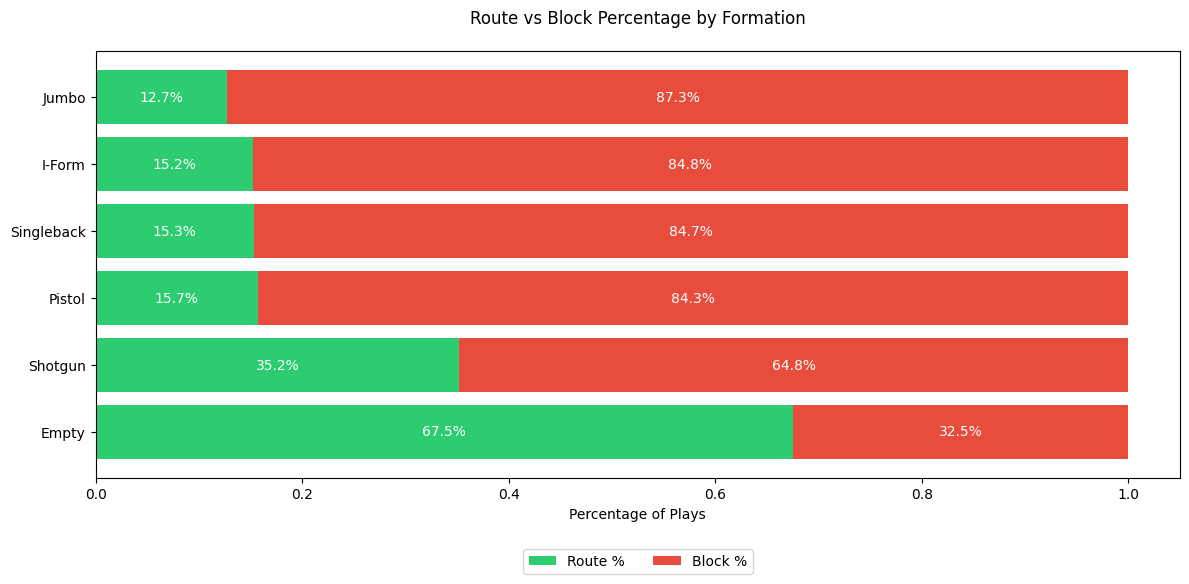

In [21]:
plt.figure(figsize=(12, 6))

formations = {
    'Empty': 0.675,
    'Shotgun': 0.352,
    'Pistol': 0.157,
    'Singleback': 0.153,
    'I-Form': 0.152,
    'Jumbo': 0.127
}

# Sort by route percentage
formations = dict(sorted(formations.items(), key=lambda x: x[1], reverse=True))

# Create horizontal bars
y_pos = np.arange(len(formations))
route_pcts = list(formations.values())
block_pcts = [1 - x for x in route_pcts]

# Create stacked bars
plt.barh(y_pos, route_pcts, color='#2ecc71', label='Route %')
plt.barh(y_pos, block_pcts, left=route_pcts, color='#e74c3c', label='Block %')

# Customize
plt.yticks(y_pos, formations.keys())
plt.xlabel('Percentage of Plays')
plt.title('Route vs Block Percentage by Formation', pad=20)
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

# Add percentage labels
for i, v in enumerate(route_pcts):
    plt.text(v/2, i, f'{v*100:.1f}%', 
             color='white', va='center', ha='center')
    plt.text(v + (block_pcts[i]/2), i, f'{block_pcts[i]*100:.1f}%', 
             color='white', va='center', ha='center')

plt.tight_layout()
plt.show()

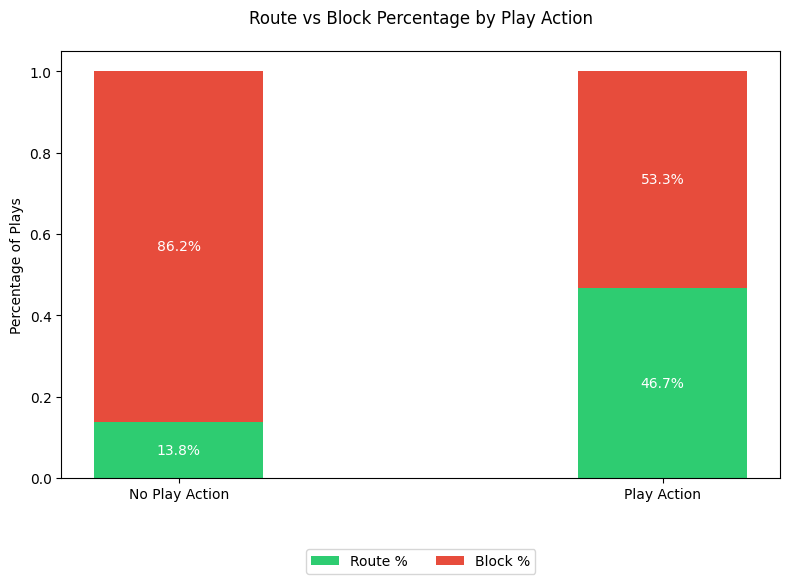

In [22]:
plt.figure(figsize=(8, 6))

labels = ['No Play Action', 'Play Action']
route_pcts = [0.138, 0.467]
block_pcts = [0.862, 0.533]

x = np.arange(len(labels))
width = 0.35

plt.bar(x, route_pcts, width, label='Route %', color='#2ecc71')
plt.bar(x, block_pcts, width, bottom=route_pcts, label='Block %', color='#e74c3c')

plt.ylabel('Percentage of Plays')
plt.title('Route vs Block Percentage by Play Action', pad=20)
plt.xticks(x, labels)
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

# Add percentage labels
for i in range(len(x)):
    plt.text(i, route_pcts[i]/2, f'{route_pcts[i]*100:.1f}%', 
             ha='center', va='center', color='white')
    plt.text(i, route_pcts[i] + block_pcts[i]/2, f'{block_pcts[i]*100:.1f}%',
             ha='center', va='center', color='white')

plt.tight_layout()
plt.show()

In [24]:
# 2. Process features (using our previous setup)
categorical_features = [
    'formation_simple',
    'pff_passCoverage', 
    'pff_manZone',
    'boundary_field',
    'field_zone',
    'score_situation',
    'game_phase'
]

boolean_features = [
    'playAction',
    'inMotionAtBallSnap',
    'shiftSinceLineset',
    'motionSinceLineset'
]

numeric_features = [
    'down',
    'yardsToGo',
    'absoluteYardlineNumber',
    'x_dist',
    'height',  # Add these from players_df
    'weight'
]

In [25]:
# 3. Encode features
# One-hot encode categorical
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = onehot.fit_transform(route_plays_all[categorical_features])
encoded_feature_names = onehot.get_feature_names_out(categorical_features)

# Create DataFrame with encoded features
categorical_df = pd.DataFrame(
    categorical_encoded, 
    columns=encoded_feature_names
)

# Convert boolean features to int
numeric_boolean_df = route_plays_all[numeric_features + boolean_features].copy()
for feature in boolean_features:
    numeric_boolean_df[feature] = numeric_boolean_df[feature].astype(int)

# Reset indices and combine
categorical_df.reset_index(drop=True, inplace=True)
numeric_boolean_df.reset_index(drop=True, inplace=True)

In [26]:
# Scale numeric features for logistic regression
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_boolean_df)
numeric_scaled_df = pd.DataFrame(numeric_scaled, columns=numeric_boolean_df.columns)

In [27]:
numeric_scaled_df.reset_index(drop=True, inplace=True)

In [28]:
X_scaled = pd.concat([categorical_df, numeric_scaled_df], axis=1)

In [57]:
X_unscaled = pd.concat([categorical_df, numeric_boolean_df], axis=1)

In [31]:
X_unscaled

,formation_simple_empty,formation_simple_i_form,formation_simple_jumbo,formation_simple_other,formation_simple_pistol,formation_simple_shotgun,formation_simple_singleback,pff_passCoverage_2-Man,pff_passCoverage_Bracket,pff_passCoverage_Cover 6-Left,pff_passCoverage_Cover-0,pff_passCoverage_Cover-1,pff_passCoverage_Cover-1 Double,pff_passCoverage_Cover-2,pff_passCoverage_Cover-3,pff_passCoverage_Cover-3 Cloud Left,pff_passCoverage_Cover-3 Cloud Right,pff_passCoverage_Cover-3 Seam,pff_passCoverage_Cover-6 Right,pff_passCoverage_Goal Line,pff_passCoverage_Miscellaneous,pff_passCoverage_Prevent,pff_passCoverage_Quarters,pff_passCoverage_Red Zone,pff_passCoverage_None,pff_manZone_Man,pff_manZone_Other,pff_manZone_Zone,pff_manZone_None,boundary_field_boundary,boundary_field_field,boundary_field_unknown,field_zone_backed_up,field_zone_opp_territory,field_zone_own_territory,field_zone_red_zone,score_situation_close,score_situation_down_1score,score_situation_down_2scores,score_situation_down_big,score_situation_up_1score,score_situation_up_2scores,score_situation_up_big,game_phase_crunch_time,game_phase_early_game,game_phase_third_quarter,game_phase_unknown,down,yardsToGo,absoluteYardlineNumber,x_dist,height,weight,playAction,inMotionAtBallSnap,shiftSinceLineset,motionSinceLineset
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,6,68,0.00,76,267,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,10,99,0.13,78,263,0,0,0,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,10,99,0.18,78,263,1,0,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,10,74,0.30,78,263,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1,65,-0.12,78,263,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,19,89,0.12,76,243,0,0,0,0
4151,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,12,87,-0.11,77,256,1,0,0,0
4152,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4,1,76,0.25,76,260,0,0,0,0
4153,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,10,75,-0.02,76,260,0,0,0,0


In [32]:
# Target variable
y = route_plays_all['ran_route']

In [33]:
# Split data for Logistic Regression
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Split data for Random Forest
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_unscaled, y, test_size=0.2, random_state=42, stratify=y
)

In [34]:
# Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.94      0.69      0.79       654
           1       0.42      0.85      0.56       177

    accuracy                           0.72       831
   macro avg       0.68      0.77      0.68       831
weighted avg       0.83      0.72      0.74       831



In [35]:
# Random Forest Grid Search
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

rf_grid.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', {0: 1, 1: 2},
                                          {0: 1, 1: 3}],
                         'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5],
                         'n_estimators': [500, 1000]},
             scoring='f1_weighted')

In [31]:
print("\nBest Random Forest Parameters:")
print(rf_grid.best_params_)
print("\nBest Score:", rf_grid.best_score_)


Best Random Forest Parameters:
{'class_weight': {0: 1, 1: 2}, 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 1000}

Best Score: 0.7934545637531354


In [32]:
# Get feature coefficients from logistic regression
coef_df = pd.DataFrame({
    'feature': X_scaled.columns,
    'coefficient': lr.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\nTop 20 Most Important Features (Logistic Regression):")
print(coef_df.head(20))


Top 20 Most Important Features (Logistic Regression):
                           feature  coefficient
0           formation_simple_empty     1.862692
53                      playAction     0.960430
5         formation_simple_shotgun     0.813982
17   pff_passCoverage_Cover-3 Seam     0.706878
18  pff_passCoverage_Cover-6 Right     0.661297
27                pff_manZone_Zone     0.629053
8         pff_passCoverage_Bracket     0.457769
13        pff_passCoverage_Cover-2     0.438340
23       pff_passCoverage_Red Zone     0.413033
48                       yardsToGo     0.406610
25                 pff_manZone_Man     0.385836
11        pff_passCoverage_Cover-1     0.301632
35             field_zone_red_zone     0.286460
26               pff_manZone_Other     0.244586
10        pff_passCoverage_Cover-0     0.243408
47                            down     0.236187
9    pff_passCoverage_Cover 6-Left     0.222156
45        game_phase_third_quarter     0.199077
7           pff_passCoverage_2-Ma

In [33]:
# Final prediction with best Random Forest model
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test_rf)

print("\nBest Random Forest Model Results:")
print(classification_report(y_test_rf, y_pred_rf))


Best Random Forest Model Results:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       654
           1       0.49      0.42      0.45       177

    accuracy                           0.78       831
   macro avg       0.67      0.65      0.66       831
weighted avg       0.77      0.78      0.78       831



In [34]:
# Feature importance from best Random Forest
rf_importance = pd.DataFrame({
    'feature': X_unscaled.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (Random Forest):")
print(rf_importance.head(20))


Top 20 Most Important Features (Random Forest):
                          feature  importance
53                     playAction    0.251528
5        formation_simple_shotgun    0.100843
50                         x_dist    0.069389
49         absoluteYardlineNumber    0.057587
52                         weight    0.055890
48                      yardsToGo    0.052600
6     formation_simple_singleback    0.031636
51                         height    0.028632
47                           down    0.018914
0          formation_simple_empty    0.017613
24          pff_passCoverage_None    0.017155
28               pff_manZone_None    0.016845
43         game_phase_crunch_time    0.014726
3          formation_simple_other    0.013394
1         formation_simple_i_form    0.012945
30           boundary_field_field    0.010802
13       pff_passCoverage_Cover-2    0.010377
36          score_situation_close    0.010332
17  pff_passCoverage_Cover-3 Seam    0.009992
45       game_phase_third_quart

In [35]:
# 1. ROC Curves for both models
# Get probabilities
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]
rf_probs = best_rf.predict_proba(X_test_rf)[:, 1]

# Calculate ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test_rf, rf_probs)

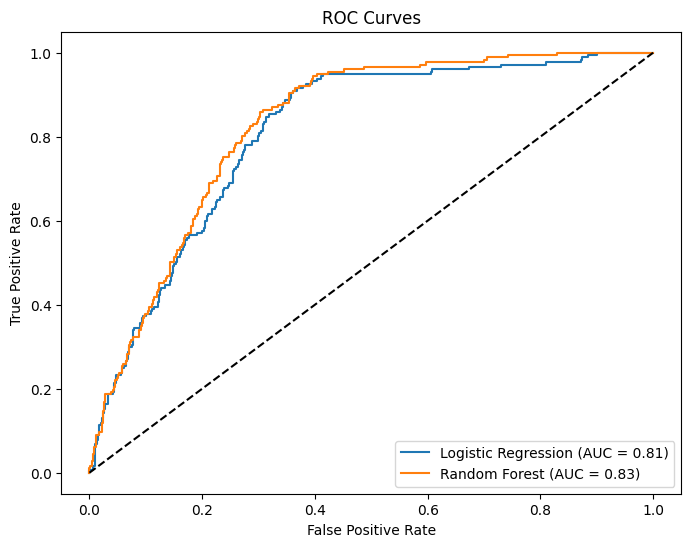

In [36]:
# Calculate AUC
lr_auc = auc(lr_fpr, lr_tpr)
rf_auc = auc(rf_fpr, rf_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [37]:
# 2. More extensive Random Forest tuning
# Focus on parameters that showed promise
finer_param_grid = {
    'n_estimators': [800, 1000, 1200],
    'max_depth': [8, 10, 12],
    'min_samples_split': [4, 5, 6],
    'class_weight': [{0:1, 1:1.5}, {0:1, 1:2}, {0:1, 1:2.5}]
}

rf_fine_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    finer_param_grid,
    cv=5,
    scoring=['f1_weighted', 'roc_auc', 'precision', 'recall'],
    refit='f1_weighted',
    n_jobs=-1
)

In [38]:
rf_fine_grid.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1.5}, {0: 1, 1: 2},
                                          {0: 1, 1: 2.5}],
                         'max_depth': [8, 10, 12],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [800, 1000, 1200]},
             refit='f1_weighted',
             scoring=['f1_weighted', 'roc_auc', 'precision', 'recall'])

In [39]:
print("\nDetailed Random Forest Results:")
print("Best Parameters:", rf_fine_grid.best_params_)
for metric in rf_fine_grid.scoring:
    scores = rf_fine_grid.cv_results_[f'mean_test_{metric}']
    print(f"Best {metric} Score: {max(scores):.4f}")


Detailed Random Forest Results:
Best Parameters: {'class_weight': {0: 1, 1: 2}, 'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 800}
Best f1_weighted Score: 0.7954
Best roc_auc Score: 0.8336
Best precision Score: 0.6317
Best recall Score: 0.5911


In [40]:
# 3. Final Model Confidence Analysis
final_rf = rf_fine_grid.best_estimator_
probabilities = final_rf.predict_proba(X_test_rf)
confidence = np.max(probabilities, axis=1)

In [46]:
y_pred_final_rf = final_rf.predict(X_test_rf)

In [47]:
print("\nFinal Random Forest Model Results:")
print(classification_report(y_test_rf, y_pred_final_rf))


Final Random Forest Model Results:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       654
           1       0.48      0.44      0.46       177

    accuracy                           0.78       831
   macro avg       0.67      0.65      0.66       831
weighted avg       0.77      0.78      0.78       831



In [43]:
# Look at high confidence predictions
high_conf_mask = confidence > 0.9
print("\nHigh Confidence Predictions (>90%):")
print("Number of predictions:", sum(high_conf_mask))
print("Accuracy on these predictions:", 
      accuracy_score(y_test_rf[high_conf_mask], 
                    final_rf.predict(X_test_rf)[high_conf_mask]))


High Confidence Predictions (>90%):
Number of predictions: 66
Accuracy on these predictions: 1.0


In [44]:
# Look at low confidence predictions
low_conf_mask = confidence < 0.6
print("\nLow Confidence Predictions (<60%):")
print("Number of predictions:", sum(low_conf_mask))
print("Accuracy on these predictions:", 
      accuracy_score(y_test_rf[low_conf_mask], 
                    final_rf.predict(X_test_rf)[low_conf_mask]))


Low Confidence Predictions (<60%):
Number of predictions: 314
Accuracy on these predictions: 0.5509554140127388


In [49]:
metrics = ['accuracy', 'precision', 'recall', 'f1']
cv_scores = {}

for metric in metrics:
    scores = cross_val_score(
        final_rf,  # our best model from grid search
        X_train_rf, 
        y_train_rf,
        cv=5,
        scoring=metric
    )
    cv_scores[metric] = {
        'mean': scores.mean(),
        'std': scores.std()
    }

In [50]:
print("Cross-validation scores:")
for metric, scores in cv_scores.items():
    print(f"{metric}: {scores['mean']:.3f} (+/- {scores['std']*2:.3f})")

Cross-validation scores:
accuracy: 0.804 (+/- 0.037)
precision: 0.551 (+/- 0.112)
recall: 0.436 (+/- 0.093)
f1: 0.486 (+/- 0.097)


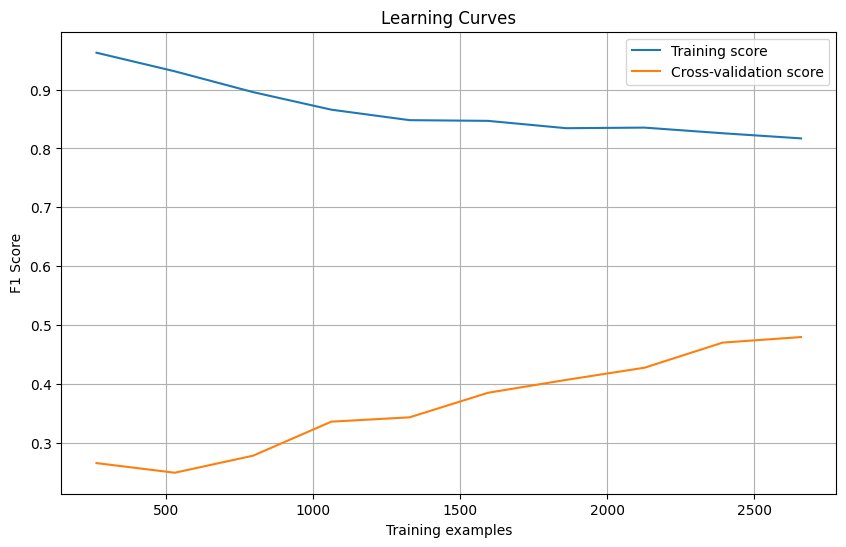

In [51]:
# 2. Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    final_rf,
    X_train_rf,
    y_train_rf,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1'
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('F1 Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Reducing overfitting

In [36]:
conservative_param_grid = {
    'n_estimators': [1000],  # Keep high number of trees
    'max_depth': [6, 8],     # Reduce max_depth
    'min_samples_split': [8, 10],  # Increase min_samples_split
    'min_samples_leaf': [4, 6],    # Add min_samples_leaf constraint
    'class_weight': [{0:1, 1:2}]   # Keep our best class weight
}

rf_conservative = GridSearchCV(
    RandomForestClassifier(random_state=42),
    conservative_param_grid,
    cv=5,
    scoring=['f1_weighted', 'roc_auc'],
    refit='f1_weighted',
    n_jobs=-1
)

# Fit the model
rf_conservative.fit(X_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 2}], 'max_depth': [6, 8],
                         'min_samples_leaf': [4, 6],
                         'min_samples_split': [8, 10], 'n_estimators': [1000]},
             refit='f1_weighted', scoring=['f1_weighted', 'roc_auc'])

In [37]:
# Print results
print("Best Parameters:", rf_conservative.best_params_)
for metric in rf_conservative.scoring:
    scores = rf_conservative.cv_results_[f'mean_test_{metric}']
    print(f"Best {metric} Score: {max(scores):.4f}")

Best Parameters: {'class_weight': {0: 1, 1: 2}, 'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 1000}
Best f1_weighted Score: 0.7888
Best roc_auc Score: 0.8282


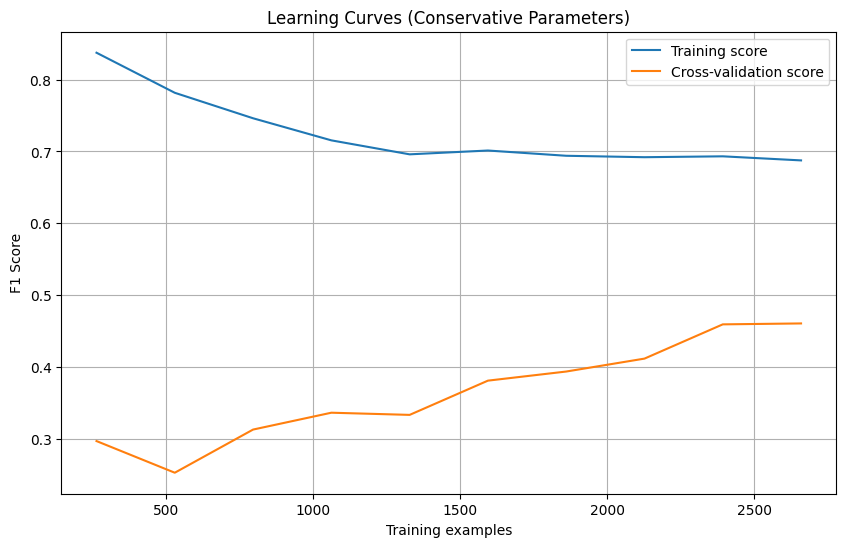

In [38]:
# Get new learning curves
train_sizes, train_scores, val_scores = learning_curve(
    rf_conservative.best_estimator_,
    X_train_rf,
    y_train_rf,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1'
)

# Plot new learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('F1 Score')
plt.title('Learning Curves (Conservative Parameters)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [39]:
# 3. Final Model Confidence Analysis
final_rf = rf_conservative.best_estimator_
probabilities = final_rf.predict_proba(X_test_rf)
confidence = np.max(probabilities, axis=1)

In [40]:
# Final performance check
y_pred_cons = rf_conservative.predict(X_test_rf)
print("\nFinal Conservative Model Performance:")
print(classification_report(y_test_rf, y_pred_cons))


Final Conservative Model Performance:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       654
           1       0.51      0.44      0.47       177

    accuracy                           0.79       831
   macro avg       0.68      0.66      0.67       831
weighted avg       0.78      0.79      0.79       831



In [43]:
# Look at high confidence predictions
high_conf_mask = confidence > 0.8
print("\nHigh Confidence Predictions (>80%):")
print("Number of predictions:", sum(high_conf_mask))
print("Accuracy on these predictions:", 
      accuracy_score(y_test_rf[high_conf_mask], 
                    rf_conservative.predict(X_test_rf)[high_conf_mask]))


High Confidence Predictions (>80%):
Number of predictions: 311
Accuracy on these predictions: 0.977491961414791


In [44]:
# Look at low confidence predictions
low_conf_mask = confidence < 0.6
print("\nLow Confidence Predictions (<60%):")
print("Number of predictions:", sum(low_conf_mask))
print("Accuracy on these predictions:", 
      accuracy_score(y_test_rf[low_conf_mask], 
                    rf_conservative.predict(X_test_rf)[low_conf_mask]))


Low Confidence Predictions (<60%):
Number of predictions: 342
Accuracy on these predictions: 0.5818713450292398


In [47]:
best_rf = rf_conservative.best_estimator_

In [48]:
# Feature importance from best Random Forest
rf_importance = pd.DataFrame({
    'feature': X_unscaled.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (Random Forest):")
print(rf_importance.head(20))


Top 20 Most Important Features (Random Forest):
                           feature  importance
53                      playAction    0.304580
5         formation_simple_shotgun    0.125983
50                          x_dist    0.058182
48                       yardsToGo    0.048652
52                          weight    0.045869
49          absoluteYardlineNumber    0.045657
6      formation_simple_singleback    0.040942
24           pff_passCoverage_None    0.025516
28                pff_manZone_None    0.023389
51                          height    0.021144
3           formation_simple_other    0.019488
0           formation_simple_empty    0.017387
43          game_phase_crunch_time    0.015628
47                            down    0.014576
1          formation_simple_i_form    0.013913
17   pff_passCoverage_Cover-3 Seam    0.010479
13        pff_passCoverage_Cover-2    0.009809
18  pff_passCoverage_Cover-6 Right    0.008742
30            boundary_field_field    0.008577
14        p

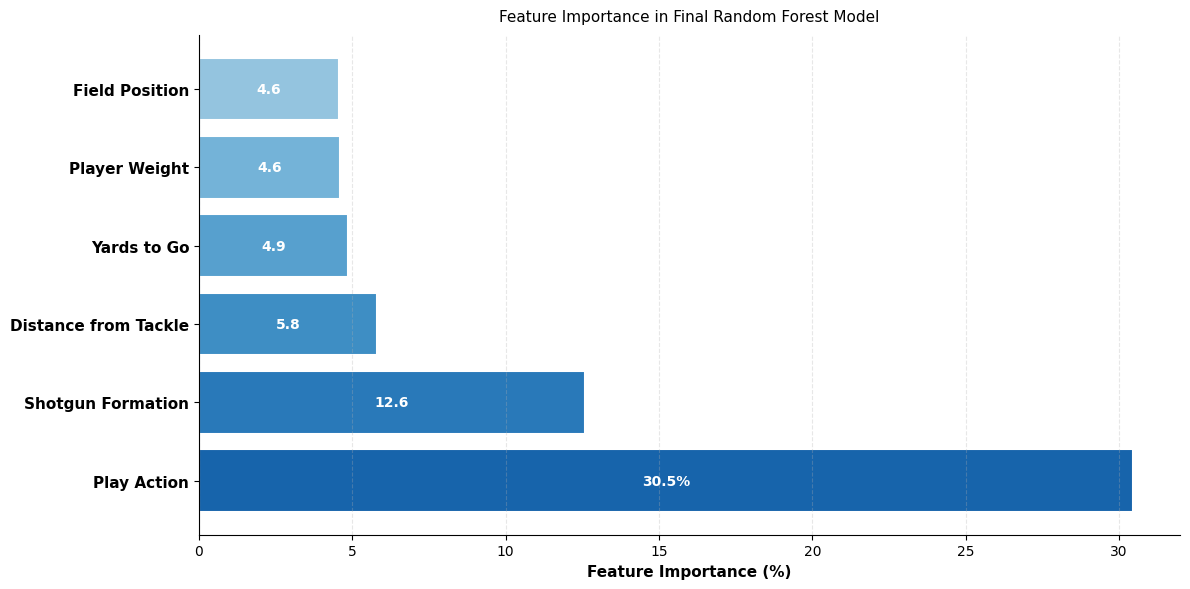

In [53]:
# Set style
plt.style.use('default')  # Using default style
plt.figure(figsize=(12, 6))

features = {
    'Play Action': 30.46,
    'Shotgun Formation': 12.60,
    'Distance from Tackle': 5.82,
    'Yards to Go': 4.87,
    'Player Weight': 4.59,
    'Field Position': 4.57
}

y_pos = np.arange(len(features))

# Create gradient colors from darker to lighter blue
colors = plt.cm.Blues(np.linspace(0.8, 0.4, len(features)))

# Create bars with gradient
bars = plt.barh(y_pos, list(features.values()), 
                color=colors,
                edgecolor='white',
                linewidth=1.5)

# Add a subtle grid
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Customize appearance
plt.yticks(y_pos, features.keys(), fontsize=11, fontweight='bold')
plt.xlabel('Feature Importance (%)', fontsize=11, fontweight='bold')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add percentage labels inside the bars
for i, v in enumerate(features.values()):
    # Only add % sign to first bar to avoid clutter
    label = f'{v:.1f}%' if i == 0 else f'{v:.1f}'
    plt.text(v/2, i, label,
             color='white',
             fontweight='bold',
             va='center',
             ha='center',
             fontsize=10)


plt.title('Feature Importance in Final Random Forest Model', 
         fontsize=11, 
         pad=10)

plt.tight_layout()
plt.show()

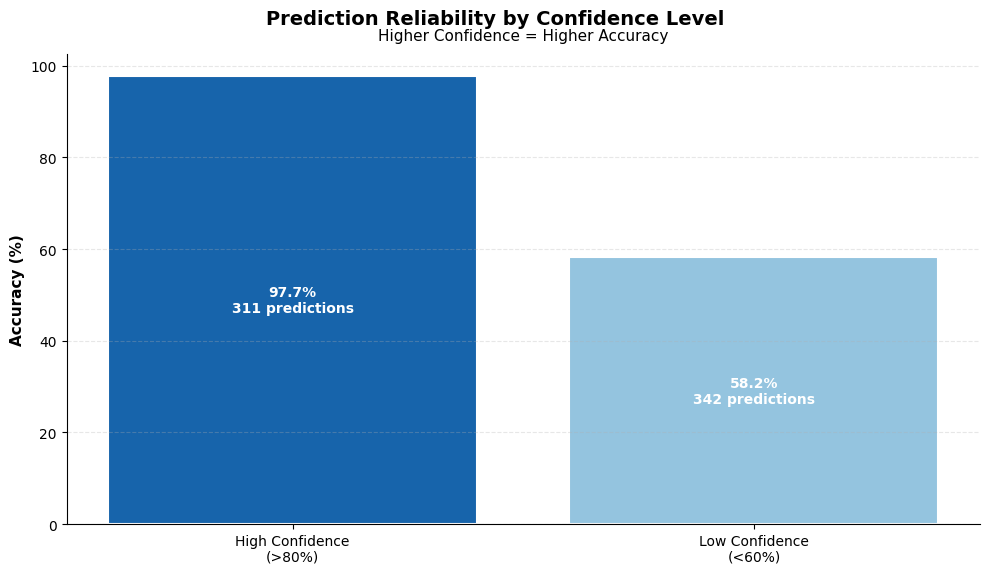

In [56]:
plt.figure(figsize=(10, 6))

# Data
confidence_levels = ['High Confidence\n(>80%)', 'Low Confidence\n(<60%)']
accuracies = [97.7, 58.2]
counts = [311, 342]

# Use same Blues colormap
colors = plt.cm.Blues([0.8, 0.4])  # Darker blue for high confidence, lighter for low

# Create bars
bars = plt.bar(confidence_levels, accuracies, 
               color=colors,
               edgecolor='white',
               linewidth=1.5)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Customize appearance
plt.ylabel('Accuracy (%)', fontsize=11, fontweight='bold')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add accuracy and count labels on bars
for i, (v, count) in enumerate(zip(accuracies, counts)):
    plt.text(i, v/2, f'{v:.1f}%\n{count} predictions',
             ha='center',
             va='center',
             color='white',
             fontweight='bold',
             fontsize=10)

# Add title with custom styling
plt.suptitle('Prediction Reliability by Confidence Level', 
            y=0.95, 
            fontsize=14, 
            fontweight='bold')
plt.title('Higher Confidence = Higher Accuracy', 
         fontsize=11, 
         pad=10)

plt.tight_layout()
plt.show()

# Initial rf work

In [42]:
# 4. Create final feature matrix
X = pd.concat([categorical_df, numeric_boolean_df], axis=1)
y = route_plays_all['ran_route']

# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [43]:
# 6. Train Random Forest
rf_binary = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

rf_binary.fit(X_train, y_train)

# 7. Make predictions
y_pred = rf_binary.predict(X_test)

In [44]:
# 8. Evaluate
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       654
           1       0.45      0.16      0.24       177

    accuracy                           0.78       831
   macro avg       0.63      0.56      0.56       831
weighted avg       0.73      0.78      0.74       831



In [45]:
# 9. Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_binary.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# 10. Confusion Matrix
conf_matrix = pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=['Block', 'Route'],
    columns=['Block', 'Route']
)
print("\nConfusion Matrix:")
print(conf_matrix)


Top 20 Most Important Features:
                        feature  importance
51                   playAction    0.147933
50                       x_dist    0.125857
49       absoluteYardlineNumber    0.118465
48                    yardsToGo    0.063891
5      formation_simple_shotgun    0.058411
47                         down    0.033106
6   formation_simple_singleback    0.025406
36        score_situation_close    0.020324
33     field_zone_opp_territory    0.017812
37  score_situation_down_1score    0.017690
34     field_zone_own_territory    0.017571
29      boundary_field_boundary    0.017366
44        game_phase_early_game    0.017340
30         boundary_field_field    0.017295
40    score_situation_up_1score    0.017178
43       game_phase_crunch_time    0.016850
14     pff_passCoverage_Cover-3    0.015525
45     game_phase_third_quarter    0.015485
22    pff_passCoverage_Quarters    0.013202
1       formation_simple_i_form    0.012649

Confusion Matrix:
       Block  Route
Bloc

In [46]:
class_counts = route_plays_all['ran_route'].value_counts()
class_weights = {
    0: 1 / class_counts[0],
    1: (1 / class_counts[1]) * 2  # Give extra weight to minority class
}

In [47]:
# 2. Try a more complex model
rf_improved = RandomForestClassifier(
    n_estimators=1000,  # More trees
    class_weight=class_weights,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

In [48]:
# 3. Create interaction features
X_with_interactions = X.copy()
# Interaction between play action and formation
X_with_interactions['playaction_shotgun'] = X['playAction'] * X['formation_simple_shotgun']
X_with_interactions['playaction_singleback'] = X['playAction'] * X['formation_simple_singleback']
# Down and distance interaction
X_with_interactions['third_and_long'] = (X['down'] == 3) & (X['yardsToGo'] > 5)

# Split and train
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_with_interactions, y, test_size=0.2, random_state=42, stratify=y
)

In [49]:
rf_improved.fit(X_train_imp, y_train_imp)
y_pred_imp = rf_improved.predict(X_test_imp)

print("Improved Model Classification Report:")
print(classification_report(y_test_imp, y_pred_imp))

Improved Model Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       654
           1       0.43      0.19      0.26       177

    accuracy                           0.77       831
   macro avg       0.62      0.56      0.56       831
weighted avg       0.73      0.77      0.74       831



In [50]:
print("\nImproved Confusion Matrix:")
print(pd.DataFrame(
    confusion_matrix(y_test_imp, y_pred_imp),
    index=['Block', 'Route'],
    columns=['Block', 'Route']
))


Improved Confusion Matrix:
       Block  Route
Block    611     43
Route    144     33


In [51]:
# Look at feature importance in improved model
feature_imp = pd.DataFrame({
    'feature': X_with_interactions.columns,
    'importance': rf_improved.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features (Improved Model):")
print(feature_imp.head(20))

# Add probability predictions to see confidence levels
y_prob = rf_improved.predict_proba(X_test_imp)
route_probs = pd.DataFrame({
    'true_value': y_test_imp,
    'predicted': y_pred_imp,
    'prob_route': y_prob[:, 1]
})

print("\nAverage probability of route prediction by true value:")
print(route_probs.groupby('true_value')['prob_route'].mean())


Top 20 Most Important Features (Improved Model):
                        feature  importance
50                       x_dist    0.119500
49       absoluteYardlineNumber    0.115891
51                   playAction    0.100002
48                    yardsToGo    0.063391
5      formation_simple_shotgun    0.056206
6   formation_simple_singleback    0.036649
56        playaction_singleback    0.032247
47                         down    0.031641
36        score_situation_close    0.020314
34     field_zone_own_territory    0.017983
37  score_situation_down_1score    0.017497
33     field_zone_opp_territory    0.017116
29      boundary_field_boundary    0.017003
44        game_phase_early_game    0.016808
40    score_situation_up_1score    0.016705
43       game_phase_crunch_time    0.016307
14     pff_passCoverage_Cover-3    0.016086
30         boundary_field_field    0.016046
24        pff_passCoverage_None    0.015115
45     game_phase_third_quarter    0.014805

Average probability of ro